In [1]:
import pandas as pd
from nltk.tokenize import sent_tokenize, PunktSentenceTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import math
from rouge import Rouge
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
sns.set()

In [2]:
def show(x):
    print(x.shape)
    return x.head()

In [3]:
references = pd.read_csv("../data/references.csv").set_index("global_reference_id")
show(references)
references.head(20)

(24757, 2)


,title,abstract
global_reference_id,,
0,Distributed Representations of Words and Phras...,The recently introduced continuous Skip-gram m...
1,BERT: Pre-training of Deep Bidirectional Trans...,We introduce a new language representation mod...
2,Attention Is All You Need,The dominant sequence transduction models are ...
3,GloVe : Global Vectors for Word Representation,Recent methods for learning vector space repre...
4,Adam: A Method for Stochastic Optimization,"We introduce Adam, an algorithm for first-orde..."
5,Long Short-Term Memory,NaN
6,Deep Contextualized Word Representations,We introduce a new type of deep contextualized...
7,Neural Machine Translation By Jointly Learning...,Neural machine translation is a recently propo...
8,Efficient Estimation of Word Representations i...,We propose two novel model architectures for c...


In [4]:
papers = pd.read_csv("../data/papers.csv").set_index("paper_id")
show(papers)

(1091, 3)


,title,abstract,text
paper_id,,,
0,IDST at TREC 2019 Deep Learning Track: Deep Ca...,This paper describes our participation in the ...,"KEYWORDS cascade ranking, pre-trained language..."
1,BatchBALD: Efficient and Diverse Batch Acquisi...,"We develop BatchBALD, a tractable approximatio...",A key problem in deep learning is data efficie...
2,A Sentence Compression Based Framework to Quer...,We consider the problem of using sentence comp...,Proceedings of the 51st Annual Meeting of the ...
3,DR-BiLSTM: Dependent Reading Bidirectional LST...,We present a novel deep learning architecture ...,Natural Language Inference (NLI; a.k.a. Recogn...
4,On Minimizing Cost in Legal Document ReviewWor...,Technology-assisted review (TAR) refers to hum...,CCS CONCEPTS • Information systems → Informati...


In [5]:
citations = pd.read_csv("../data/citations.csv")
show(citations)

(56746, 6)


,paper_id,internal_reference_id,global_reference_id,context,start_offset,end_offset
0,0,1,1,Our approach is mainly based on the BERT langu...,56,59
1,0,8,475,Different from many other ranking methods whic...,216,219
2,0,5,155,"Moreover, for full ranking subtask, we use a s...",78,81
3,0,6,25,The proposed model is based on the pointer-gen...,59,62
4,0,6,25,"Following [7], we also use a soft switch to ch...",10,13


In [6]:
citations.context[1]

'Different from many other ranking methods which directly finetune the original BERT model in downstream task, we modify the next sentence prediction task in BERT to a 3-class sentence classification as in StructBERT [9] and pre-train a new BERT language model from scratch.'

In [7]:
citations.groupby(["paper_id", "global_reference_id"]).size()

paper_id  global_reference_id
0         1                      2
          2                      1
          13                     1
          21                     1
          25                     3
                                ..
1090      18917                  1
          20566                  1
          21397                  1
          21484                  1
          23601                  1
Length: 33068, dtype: int64

# rouge against original abstract

In [8]:
retrieved = citations.groupby(["paper_id", "global_reference_id"]).context.sum().reset_index()
show(retrieved)

(33068, 3)


,paper_id,global_reference_id,context
0,0,1,Our approach is mainly based on the BERT langu...
1,0,2,BERT [2] is a self-supervised approach for pre...
2,0,13,"Recently, some variants [4, 12] of BERT langua..."
3,0,21,"Recently, some variants [4, 12] of BERT langua..."
4,0,25,The proposed model is based on the pointer-gen...


In [9]:
retrieved.iloc[1].context

'BERT [2] is a self-supervised approach for pre-training a deep transformer encoder [8], before fine-tuning it for a particular downstream task.'

In [10]:
queries = retrieved.merge(references.drop(columns = "title"), on = "global_reference_id")\
.merge(papers.drop(columns = ["abstract", "title"]), on = "paper_id")\
.rename(columns = {"abstract":"reference", "context":"hypothesis", "text":"paper_text"})\
.dropna()\
.reset_index(drop = True)
show(queries)

(11437, 5)


,paper_id,global_reference_id,hypothesis,reference,paper_text
0,0,1,Our approach is mainly based on the BERT langu...,We introduce a new language representation mod...,"KEYWORDS cascade ranking, pre-trained language..."
1,0,2,BERT [2] is a self-supervised approach for pre...,The dominant sequence transduction models are ...,"KEYWORDS cascade ranking, pre-trained language..."
2,0,13,"Recently, some variants [4, 12] of BERT langua...",Language model pretraining has led to signific...,"KEYWORDS cascade ranking, pre-trained language..."
3,0,21,"Recently, some variants [4, 12] of BERT langua...",With the capability of modeling bidirectional ...,"KEYWORDS cascade ranking, pre-trained language..."
4,0,25,The proposed model is based on the pointer-gen...,Neural sequence-to-sequence models have provid...,"KEYWORDS cascade ranking, pre-trained language..."


In [11]:
rouge = Rouge()
scores = rouge.get_scores(hyps = queries.hypothesis, refs = queries.reference)
print(len(scores))
scores[:5]

11437


[{'rouge-1': {'r': 0.11607142857142858,
   'p': 0.3939393939393939,
   'f': 0.17931034131177173},
  'rouge-2': {'r': 0.014084507042253521,
   'p': 0.04878048780487805,
   'f': 0.021857920020305732},
  'rouge-l': {'r': 0.10714285714285714,
   'p': 0.36363636363636365,
   'f': 0.1655172378634959}},
 {'rouge-1': {'r': 0.03333333333333333,
   'p': 0.2222222222222222,
   'f': 0.05797101222432271},
  'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
  'rouge-l': {'r': 0.03333333333333333,
   'p': 0.2222222222222222,
   'f': 0.05797101222432271}},
 {'rouge-1': {'r': 0.07216494845360824,
   'p': 0.2916666666666667,
   'f': 0.11570247615873239},
  'rouge-2': {'r': 0.008, 'p': 0.04, 'f': 0.013333330555556135},
  'rouge-l': {'r': 0.061855670103092786, 'p': 0.25, 'f': 0.09917355053889772}},
 {'rouge-1': {'r': 0.08247422680412371,
   'p': 0.3333333333333333,
   'f': 0.13223140177856713},
  'rouge-2': {'r': 0.0078125, 'p': 0.04, 'f': 0.013071892690845972},
  'rouge-l': {'r': 0.07216494845360824,
   'p': 0.

In [12]:
rouge_df = pd.DataFrame.from_records(scores)
show(rouge_df)

(11437, 3)


,rouge-1,rouge-2,rouge-l
0,"{'r': 0.11607142857142858, 'p': 0.393939393939...","{'r': 0.014084507042253521, 'p': 0.04878048780...","{'r': 0.10714285714285714, 'p': 0.363636363636..."
1,"{'r': 0.03333333333333333, 'p': 0.222222222222...","{'r': 0.0, 'p': 0.0, 'f': 0.0}","{'r': 0.03333333333333333, 'p': 0.222222222222..."
2,"{'r': 0.07216494845360824, 'p': 0.291666666666...","{'r': 0.008, 'p': 0.04, 'f': 0.013333330555556...","{'r': 0.061855670103092786, 'p': 0.25, 'f': 0...."
3,"{'r': 0.08247422680412371, 'p': 0.333333333333...","{'r': 0.0078125, 'p': 0.04, 'f': 0.01307189269...","{'r': 0.07216494845360824, 'p': 0.291666666666..."
4,"{'r': 0.13333333333333333, 'p': 0.318181818181...","{'r': 0.029850746268656716, 'p': 0.07272727272...","{'r': 0.12380952380952381, 'p': 0.295454545454..."


In [13]:
rouge_1 = pd.DataFrame.from_records(rouge_df["rouge-1"])\
.rename(columns = {"f":"rouge_1_f", "r":"rouge_1_r", "p":"rouge_1_p"})
show(rouge_1)

(11437, 3)


,rouge_1_r,rouge_1_p,rouge_1_f
0,0.116071,0.393939,0.179310
1,0.033333,0.222222,0.057971
2,0.072165,0.291667,0.115702
3,0.082474,0.333333,0.132231
4,0.133333,0.318182,0.187919


In [14]:
rouge_2 = pd.DataFrame.from_records(rouge_df["rouge-2"])\
.rename(columns = {"f":"rouge_2_f", "r":"rouge_2_r", "p":"rouge_2_p"})
show(rouge_2)

(11437, 3)


,rouge_2_r,rouge_2_p,rouge_2_f
0,0.014085,0.048780,0.021858
1,0.000000,0.000000,0.000000
2,0.008000,0.040000,0.013333
3,0.007812,0.040000,0.013072
4,0.029851,0.072727,0.042328


In [15]:
rouge_l = pd.DataFrame.from_records(rouge_df["rouge-l"])\
.rename(columns = {"f":"rouge_l_f", "r":"rouge_l_r", "p":"rouge_l_p"})
show(rouge_l)

(11437, 3)


,rouge_l_r,rouge_l_p,rouge_l_f
0,0.107143,0.363636,0.165517
1,0.033333,0.222222,0.057971
2,0.061856,0.250000,0.099174
3,0.072165,0.291667,0.115702
4,0.123810,0.295455,0.174497


In [16]:
full_rouge = pd.concat((queries, rouge_1, rouge_2, rouge_l), axis = 1)
show(full_rouge)

(11437, 14)


,paper_id,global_reference_id,hypothesis,reference,paper_text,rouge_1_r,rouge_1_p,rouge_1_f,rouge_2_r,rouge_2_p,rouge_2_f,rouge_l_r,rouge_l_p,rouge_l_f
0,0,1,Our approach is mainly based on the BERT langu...,We introduce a new language representation mod...,"KEYWORDS cascade ranking, pre-trained language...",0.116071,0.393939,0.179310,0.014085,0.048780,0.021858,0.107143,0.363636,0.165517
1,0,2,BERT [2] is a self-supervised approach for pre...,The dominant sequence transduction models are ...,"KEYWORDS cascade ranking, pre-trained language...",0.033333,0.222222,0.057971,0.000000,0.000000,0.000000,0.033333,0.222222,0.057971
2,0,13,"Recently, some variants [4, 12] of BERT langua...",Language model pretraining has led to signific...,"KEYWORDS cascade ranking, pre-trained language...",0.072165,0.291667,0.115702,0.008000,0.040000,0.013333,0.061856,0.250000,0.099174
3,0,21,"Recently, some variants [4, 12] of BERT langua...",With the capability of modeling bidirectional ...,"KEYWORDS cascade ranking, pre-trained language...",0.082474,0.333333,0.132231,0.007812,0.040000,0.013072,0.072165,0.291667,0.115702
4,0,25,The proposed model is based on the pointer-gen...,Neural sequence-to-sequence models have provid...,"KEYWORDS cascade ranking, pre-trained language...",0.133333,0.318182,0.187919,0.029851,0.072727,0.042328,0.123810,0.295455,0.174497


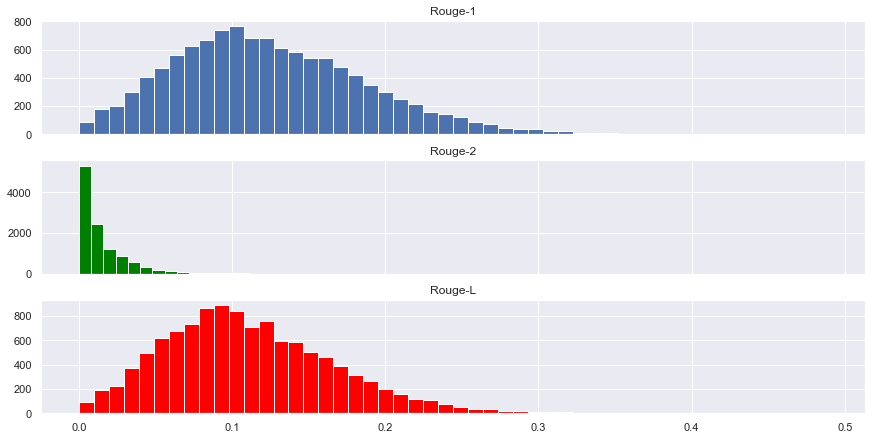

In [17]:
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].hist(full_rouge.rouge_1_f, bins = 50)
ax[0].set_title("Rouge-1")
ax[1].hist(full_rouge.rouge_2_f, bins = 50, color = "green")
ax[1].set_title("Rouge-2")
ax[2].hist(full_rouge.rouge_l_f, bins = 50, color = "red")
ax[2].set_title("Rouge-L")

plt.show()

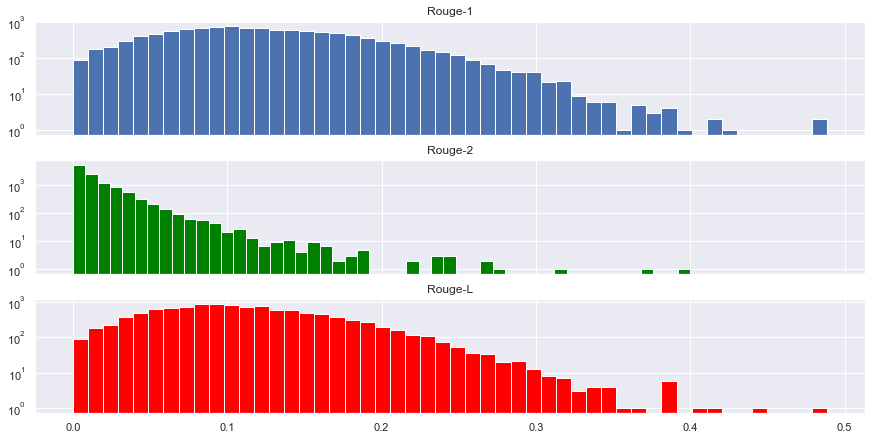

In [18]:
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].hist(full_rouge.rouge_1_f, bins = 50, log = True)
ax[0].set_title("Rouge-1")
ax[1].hist(full_rouge.rouge_2_f, bins = 50, color = "green", log = True)
ax[1].set_title("Rouge-2")
ax[2].hist(full_rouge.rouge_l_f, bins = 50, color = "red", log = True)
ax[2].set_title("Rouge-L")

plt.show()

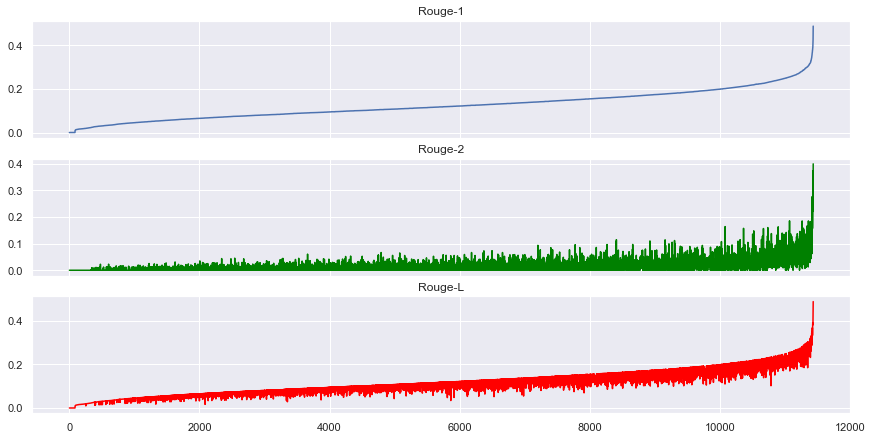

In [19]:
data = full_rouge.sort_values("rouge_1_f").reset_index()
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].plot(data.rouge_1_f)
ax[0].set_title("Rouge-1")
ax[1].plot(data.rouge_2_f, color = "green")
ax[1].set_title("Rouge-2")
ax[2].plot(data.rouge_l_f, color = "red")
ax[2].set_title("Rouge-L")

plt.show()

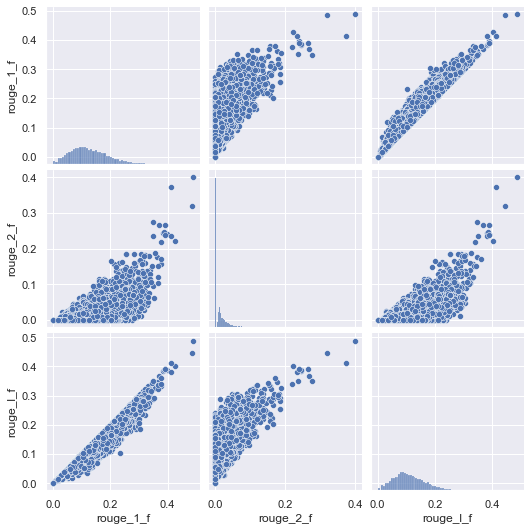

In [20]:
sns.pairplot(full_rouge, vars = ["rouge_1_f","rouge_2_f", "rouge_l_f"])
plt.show()

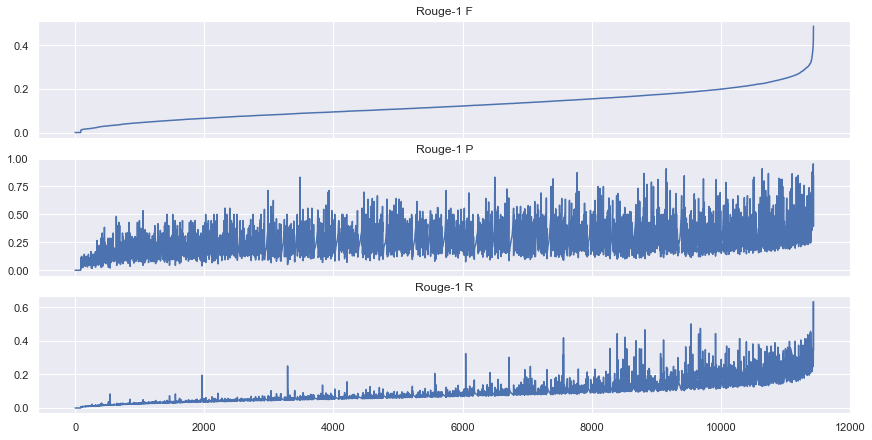

In [21]:
data = full_rouge.sort_values("rouge_1_f").reset_index()
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].plot(data.rouge_1_f)
ax[0].set_title("Rouge-1 F")
ax[1].plot(data.rouge_1_p)
ax[1].set_title("Rouge-1 P")
ax[2].plot(data.rouge_1_r)
ax[2].set_title("Rouge-1 R")

plt.show()

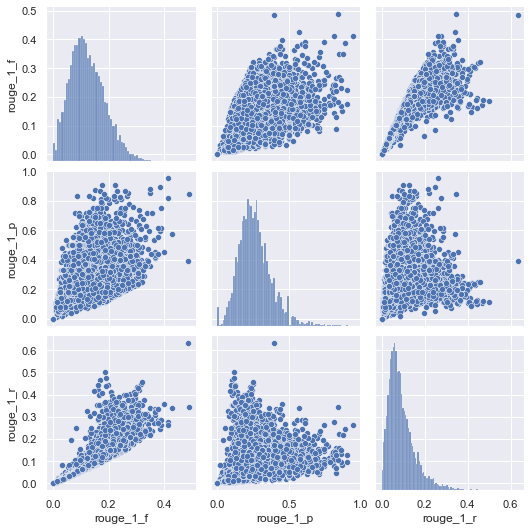

In [22]:
sns.pairplot(full_rouge, vars = ["rouge_1_f","rouge_1_p", "rouge_1_r"])
plt.show()

In [23]:
full_rouge[["rouge_1_f", "rouge_2_f", "rouge_l_f"]].describe(percentiles = np.linspace(0, 1, 11))

,rouge_1_f,rouge_2_f,rouge_l_f
count,11437.000000,11437.000000,11437.000000
mean,0.124930,0.014928,0.111416
std,0.063204,0.022873,0.056032
min,0.000000,0.000000,0.000000
0%,0.000000,0.000000,0.000000
10%,0.048387,0.000000,0.044877
20%,0.069944,0.000000,0.063158
30%,0.086957,0.000000,0.078740
40%,0.101911,0.000000,0.091503
50%,0.117647,0.009524,0.104478
